In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from tensorflow import keras

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
tf.device('/device:GPU:0')

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv("/content/drive/MyDrive/Crypto/btcusdt_15m.csv")

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
df_for_training = df.iloc[:140786]

In [8]:
df.shape

(140786, 6)

In [ ]:
features = df_for_training.drop("datetime",axis=1)

# Split the data into training (80%), validation (10%), and testing (10%) sets
train_size = int(len(features) * 0.8)
val_size = int(len(features) * 0.1)

train_features, val_features, test_features = features[:train_size], features[train_size:train_size + val_size], features[train_size + val_size:]

# Normalize the features using MinMaxScaler
features_scaler = MinMaxScaler(feature_range=(0, 1))
train_features_normalized = features_scaler.fit_transform(train_features)
val_features_normalized = features_scaler.transform(val_features)
test_features_normalized = features_scaler.transform(test_features)

In [11]:
features = df_for_training.drop("datetime",axis=1)

train_features = features
features_scaler = MinMaxScaler(feature_range=(0, 1))
train_features_normalized = features_scaler.fit_transform(train_features)

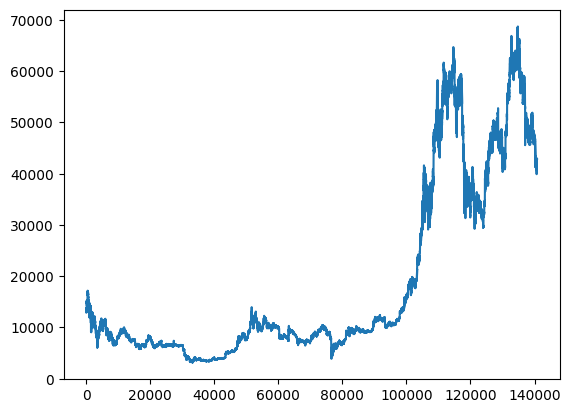

In [12]:
plt.plot(df.close)

In [13]:
features

,open,high,low,close,volume
0,13715.65,13715.65,13400.01,13556.15,123.616013
1,13533.75,13550.87,13402.00,13521.12,98.136430
2,13500.00,13545.37,13450.00,13470.41,79.904037
3,13494.65,13690.87,13450.00,13529.01,141.699719
4,13528.99,13571.74,13402.28,13445.63,72.537533
...,...,...,...,...,...
140781,42713.12,42886.28,42665.26,42874.90,220.280580
140782,42874.90,42875.05,42758.00,42790.01,138.050550
140783,42790.00,42822.21,42693.00,42790.03,158.322150
140784,42790.04,42819.89,42633.97,42729.29,164.488730


In [14]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 70  # Number of past days we want to use to predict the future.

In [15]:
train_features

,open,high,low,close,volume
0,13715.65,13715.65,13400.01,13556.15,123.616013
1,13533.75,13550.87,13402.00,13521.12,98.136430
2,13500.00,13545.37,13450.00,13470.41,79.904037
3,13494.65,13690.87,13450.00,13529.01,141.699719
4,13528.99,13571.74,13402.28,13445.63,72.537533
...,...,...,...,...,...
140781,42713.12,42886.28,42665.26,42874.90,220.280580
140782,42874.90,42875.05,42758.00,42790.01,138.050550
140783,42790.00,42822.21,42693.00,42790.03,158.322150
140784,42790.04,42819.89,42633.97,42729.29,164.488730


In [16]:
for i in range(n_past, len(train_features_normalized) - n_future +1):
    trainX.append(train_features_normalized[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(train_features_normalized[i + n_future - 1:i + n_future,3])

In [17]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('valdX shape == {}.'.format(trainX.shape))
print('valdY shape == {}.'.format(trainY.shape))

valdX shape == (140716, 70, 5).
valdY shape == (140716, 1).


In [18]:
import numpy as np

# Assuming train_x and train_y are numpy arrays

# Number of total samples
total_samples = len(trainX)

# Define the indices for splitting
train_indices = np.arange(0, total_samples - 28000)
val_indices = np.arange(total_samples - 28000, total_samples - 14000)
test_indices = np.arange(total_samples - 14000, total_samples)

# Split the data
train_X, valX, testX = trainX[train_indices], trainX[val_indices], trainX[test_indices]
train_Y, valY, testY = trainY[train_indices], trainY[val_indices], trainY[test_indices]

print(train_X.shape, valX.shape, testX.shape)

(112716, 70, 5) (14000, 70, 5) (14000, 70, 5)


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed

# Define your GARCH model
model = Sequential()
model.add(LSTM(500, activation= 'tanh',return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))
model.add(LSTM(units=500, activation='tanh',return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=500, activation='tanh',return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=500, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # Output layer with 1 neuron for each time step
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_X, train_Y, epochs=5, batch_size=64, validation_data=(valX,valY), verbose=1)


Epoch 1/5
1762/1762 [==============================] - 160s 85ms/step - loss: 8.6540e-04 - val_loss: 6.5025e-04
Epoch 2/5
1762/1762 [==============================] - 149s 85ms/step - loss: 5.2838e-05 - val_loss: 8.0826e-04
Epoch 3/5
1762/1762 [==============================] - 150s 85ms/step - loss: 4.3631e-05 - val_loss: 1.6011e-04
Epoch 4/5
1762/1762 [==============================] - 150s 85ms/step - loss: 7.7610e-05 - val_loss: 9.1451e-04
Epoch 5/5
1762/1762 [==============================] - 149s 85ms/step - loss: 4.3728e-05 - val_loss: 8.8994e-04


In [29]:
predicts = model.predict(testX)

438/438 [==============================] - 9s 20ms/step


In [30]:
print(mean_squared_error(predicts , testY))

0.0011192610138275494


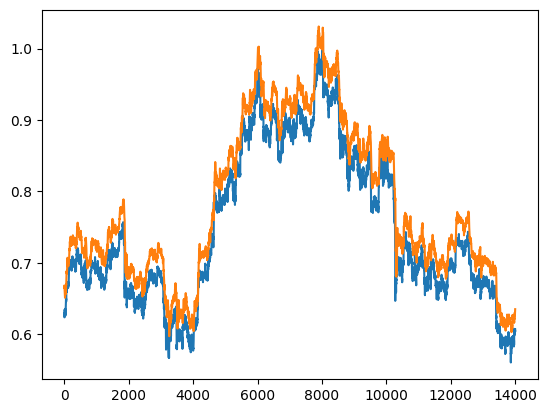

In [34]:
plt.plot(testY)
plt.plot(predicts)

## future prediction

In [37]:
current_batch = valX[-1:]

In [42]:
current_batch

array([[[0.59325966, 0.591418  , 0.59419608, 0.59400218, 0.01701003],
        [0.59400806, 0.59280015, 0.59570181, 0.59466105, 0.01022295],
        [0.59466708, 0.59324101, 0.59687091, 0.59522091, 0.00856934],
        [0.59522693, 0.59286122, 0.59616519, 0.59400599, 0.00846927],
        [0.59401203, 0.59407656, 0.59589102, 0.59561998, 0.01234596],
        [0.59564369, 0.59490511, 0.59748156, 0.59715831, 0.02254934],
        [0.5971643 , 0.59935812, 0.59770889, 0.59581205, 0.04083718],
        [0.59581806, 0.59362065, 0.59385072, 0.5925499 , 0.02881592],
        [0.5925558 , 0.59070141, 0.59356292, 0.592275  , 0.01334862],
        [0.59228106, 0.59072678, 0.59223293, 0.59087488, 0.0152466 ],
        [0.59088097, 0.59045576, 0.59285414, 0.59268445, 0.00897838],
        [0.59269035, 0.59146813, 0.59487087, 0.59380417, 0.01156733],
        [0.59381036, 0.59207185, 0.5939366 , 0.59216852, 0.01506686],
        [0.59217443, 0.59083479, 0.59386894, 0.59174931, 0.01500077],
        [0.59175538,

In [38]:
current_pred = model.predict(current_batch)

1/1 [==============================] - 0s 31ms/step


In [46]:
current_pred.shape

(1, 1)

In [59]:
future_predictions = []  ## list of future values

current_batch = valX[-1:]   ## using the last 7 days of past to predict the next future day

for _ in range(10):    ## iterating the same for 14 days future forecast

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)

    # print("Current_pred: {}".format(current_pred))
    # append the prediction into the array
    future_predictions.append(current_pred[0][0])

    # use the prediction to update the batch and remove the first value
    current_batch= np.delete(current_batch,0,axis=1)
    current_pred = np.repeat(current_pred, 5, axis=1)
    current_pred = current_pred.reshape((1,1,5))
    current_batch = np.append(current_batch,current_pred,axis=1)

    # print("Current_batch: {}".format(current_batch))

1/1 [==============================] - 0s 32ms/step


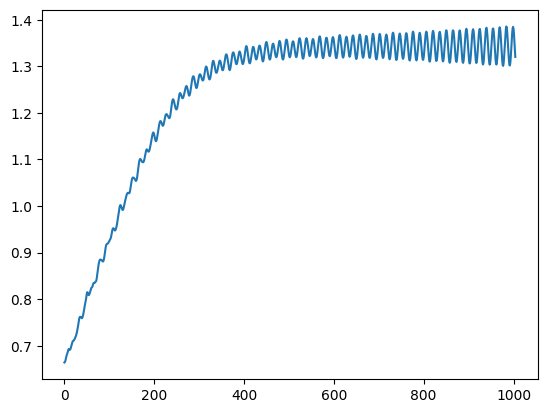

In [52]:
plt.plot(future_predictions)

In [61]:
expanded_list = [item for item in future_predictions for _ in range(5)]

# Reshape the expanded list into a 100x5 matrix
reshaped_matrix = [expanded_list[i:i+5] for i in range(0, len(expanded_list), 5)]

In [62]:
future_predictins = features_scaler.inverse_transform(reshaped_matrix)

In [66]:
future_predictins[:,3]

array([46715.7153946 , 46764.08645065, 46916.51779228, 47183.34394643,
       47478.86062275, 47715.11298743, 47882.94257881, 48082.50639614,
       48342.53012633, 48564.94711868])

In [41]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your trained model
model.save("/content/drive/MyDrive/Crypto/model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
